In [1]:
%gui tk
%matplotlib inline

import numpy as np
import os
import tkinter as tk
from tkinter import filedialog
import pandas as pd
from glob import glob
# from skimage.io import imread
import PIL.Image
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
#to increase accuracy, all images should have the same initial pixel/µm resolution

IMAGE_HEIGHT = 416
IMAGE_WIDTH = 416
IMAGE_CHANNELS = 3
BOX_WIDTH = 30 #px
BOX_HEIGHT = 30 #px

In [3]:
#initialize tkinter stuff
root = tk.Tk()
root.withdraw()

''

In [4]:
# Create a dataframe for images and coordinates
data_dir = os.path.normpath(filedialog.askdirectory())
all_images = glob(os.path.join(data_dir, '*', '*.tif'))
all_info = glob(os.path.join(data_dir, '*', '*.txt'))
img_df = pd.DataFrame({'img_path': all_images, 'info_path': all_info})
img_id = lambda in_path: in_path.split('\\')[-2][-6:]
img_df['ImageID'] = img_df['img_path'].map(img_id)

In [13]:
# define regular expressions to get coordinates
regexp_x = re.compile("x = (-?[0-9.]*),")
regexp_y = re.compile("y = (-?[0-9.]*)\n")
# TODO: figure out how to deal with negative coordinates (errors?) 

In [14]:
# function to read coordinates from text file
def read_and_parse_coordinates(info_file):
    file = open(info_file, "r")
    lines = file.readlines()
    x = []
    y = []
    for line in lines:
        xi = regexp_x.search(line)
        if xi:
            x.append(xi.group(1))
            y.append(regexp_y.search(line).group(1))
    file.close()
    return np.array([np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)])

In [7]:
# function to read images from files
def load_image(img_file):
    image = np.array(PIL.Image.open(img_file), dtype = np.uint8)
#     image = imread(img_file)
    image = np.stack([image,image,image], 2)
    return image

In [15]:
# load coordinates and images from files
img_df['x_y_coordinates'] = img_df['info_path'].map(read_and_parse_coordinates)
img_df['images'] = img_df['img_path'].map(load_image)

In [16]:
img_df.sample(1)

,img_path,info_path,ImageID,x_y_coordinates,images
2095,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,C:\Users\smirnovm\Documents\Data\Labeled_Spine...,002096,"[[64.0, 96.0, 101.0, 62.0, 105.0, 89.0], [49.0...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


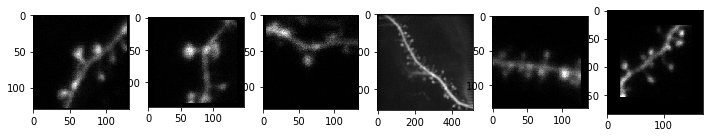

In [17]:
#Show a few sample images
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(img_df['images'].sample(n_img), range(6)):
    m_axs[ax_ind].imshow(img)

plt.show(fig)

In [18]:
# function to identify which images need to be expanded 
def flag_big_images(image):
    orig_height, orig_width = image.shape[0], image.shape[1]
    big_image_flag = False
    if orig_height > IMAGE_HEIGHT or orig_width > IMAGE_WIDTH:
        big_image_flag = True
    return big_image_flag

In [19]:
# flag big images
img_df['big_image_flag'] = img_df['images'].map(flag_big_images)

In [ ]:
# check that flag worked
# img_df.loc[1835:1837]

In [43]:
# function to split images into proper heights/widths
# any files split too small will be padded later on
# this function should only take rows of images which have been flagged as large
def split_large_images_and_coordinates(row):
    image = row['images']
    orig_height, orig_width = image.shape[0], image.shape[1]
    #first, split images by height
    split_indices_height = np.array(range(IMAGE_HEIGHT,orig_height,IMAGE_HEIGHT))
    split_indices_width = np.array(range(IMAGE_WIDTH,orig_width,IMAGE_WIDTH))        
    images_split_height = np.split(image, split_indices_height, axis = 0)
    #split coordinates by y, accordingly
    x_y_coordinates = row['x_y_coordinates']
    if len(split_indices_width) > 0:
        x_indices = np.digitize(x_y_coordinates[0], split_indices_width)
    else: x_indices = np.zeros(x_y_coordinates[0].shape, dtype = np.uint8)
            
    if len(split_indices_height) > 0:
        y_indices = np.digitize(x_y_coordinates[1], split_indices_height)
    else: y_indices = np.zeros(x_y_coordinates[1].shape, dtype = np.uint8)

    # coordinates are split into matrix in shape of split image
    coordinates_split = np.empty((len(split_indices_height)+1,len(split_indices_width)+1), dtype = np.object)
    for x,y,x_ind,y_ind in zip(x_y_coordinates[0,:], x_y_coordinates[1,:],x_indices,y_indices):
        if coordinates_split[y_ind,x_ind] is None:
            coordinates_split[y_ind,x_ind] = []
        # correct coordinates for amount of pixels which are removed before them
        # this only works if coordinates are calculated from top left so make sure that's the case
        x_corrected = x - x_ind * IMAGE_WIDTH
        y_corrected = y - y_ind * IMAGE_HEIGHT
        coordinates_split[y_ind,x_ind].append([x_corrected,y_corrected])
    # flatten coordinate matrix so its shape aligns with images_split
    coordinates_split = coordinates_split.flatten().tolist()
    images_split = []
    #create now, split images by width and create list of all images
    for image_split_height in images_split_height:
        images_split += np.split(image_split_height, split_indices_width, axis = 1)
    return images_split, coordinates_split

In [44]:
# split images and coordinates and put them in new dataframe
images_split_all = []
coordinates_split_all = []
#create row with dataframe structure to add on to
df_addon = img_df.loc[[0]].copy()
for index,row in img_df[img_df['big_image_flag']].iterrows():
    # create dummy row from current one
    clean_row = img_df.loc[[index]].copy()
    clean_row['images'] = None
    clean_row['x_y_coordinates'] = None
    images_split, coordinates_split = split_large_images_and_coordinates(row)
    images_split_all += images_split
    coordinates_split_all += coordinates_split
    df_addon = df_addon.append([clean_row]*len(images_split), ignore_index = True)
df_addon = df_addon.drop(index = 0)
df_addon['images']=np.array(images_split_all)
df_addon['x_y_coordinates'] = np.array(coordinates_split_all)
# df_addon.sample(1)

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 0
0 0
0 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 1
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 1
0 1
0 1
1 1
0 1
1 0
0 1
0 1
0 0
0 0
0 0


1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


0 0
1 0
0 0
0 0
0 0
1 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 1
0 0
0 1
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
1 0
0 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0


0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


0 1
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 1
0 1
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
1 0
1 1
1 1
0 0
0 0
1 1
1 1
0 0
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1


0 0
1 0
1 0
1 0
0 0
1 0
1 0
0 0
0 1
0 0
0 0
0 0
1 0
1 0
1 1
0 0
0 0
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1


0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [45]:
# remove big images from original dataframe and append new rows
img_df = img_df.drop(index = img_df[img_df['big_image_flag']].index)
img_df = img_df.append(df_addon,ignore_index = True)
# rename big_image_flag column to split_image
img_df = img_df.rename(columns = {'big_image_flag':'split_image'})
# img_df.loc[[len(img_df)-10]]

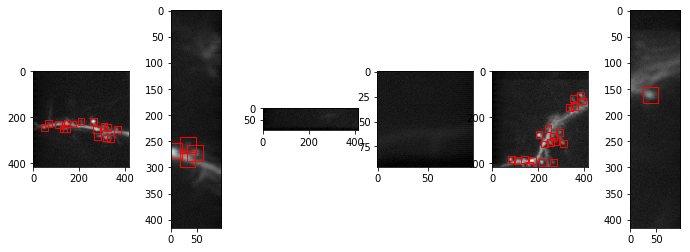

In [46]:
#Show a few sample split images with boxes
n_img = 6
fig, m_axs = plt.subplots(1, n_img, figsize=(12, 4))
for img,ax_ind in zip(images_split_all[:n_img], range(6)):
    m_axs[ax_ind].imshow(img)
    if coordinates_split_all[ax_ind] is not None:
        for x,y in coordinates_split_all[ax_ind]:
            x_rect = x-BOX_WIDTH/2
            y_rect = y-BOX_HEIGHT/2
            rect = patches.Rectangle((x_rect,y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
            m_axs[ax_ind].add_patch(rect)
plt.show(fig)

In [47]:
# get image shapes
img_df['shape'] = img_df['images'].map(lambda x: x.shape)
# img_df.sample(2)

In [48]:
# Calculate max dimensions
# max_y,max_x,max_z = 0,0,0
# for y,x,z in img_df['shape']:
#     max_x = np.max([max_x, x])
#     max_y = np.max([max_y, y])
#     max_z = np.max([max_z, z])
# max_y, max_x, max_z
max_y, max_x, max_z = IMAGE_HEIGHT, IMAGE_WIDTH, 3

In [64]:
# function to pad images and shift coordinates accordingly

def pad_image_and_shift_coordinates(row):
    image = row['images']
    y,x,z = image.shape
    pad_y, pad_x, pad_z = max_y - y, max_x - x, max_z - z
    y1,y2 = np.floor(pad_y/2).astype(int), np.floor(pad_y/2).astype(int) + pad_y%2
    x1,x2 = np.floor(pad_x/2).astype(int), np.floor(pad_x/2).astype(int) + pad_x%2
    z1,z2 = np.floor(pad_z/2).astype(int), np.floor(pad_z/2).astype(int) + pad_z%2
    row['images_padded'] = np.pad(image, ((y1,y2),(x1,x2),(z1,z2)), mode = 'constant')
    if row['x_y_coordinates'] is None:
        row['x_y_coordinates_shifted'] = None
        return row
    row['x_y_coordinates_shifted'] = row['x_y_coordinates'].copy()
    print(len(row['x_y_coordinates_shifted']))
    row['x_y_coordinates_shifted'][0] = row['x_y_coordinates'][0] + x1
    row['x_y_coordinates_shifted'][1] = row['x_y_coordinates'][1] + y1
    return row

In [60]:
#function to make boxes from given coordinates
def coords_to_boxes(x_y_coordinates):
    #boxes is an array of shape (num_boxes,5) containing 1D list of class, x_min, y_max, x_max, y_max.
    # class is always labeled as "1" for spine since that's the only thing we're looking for. DOOOEEEEEE
    boxes = []
    if len(x_y_coordinates)>0:
        for x,y in zip(x_y_coordinates[0], x_y_coordinates[1]):
            box = np.array([1, x-BOX_WIDTH/2,y-BOX_HEIGHT/2, x+BOX_WIDTH/2,y+BOX_HEIGHT/2])
            boxes.append(box)
    return np.array(boxes)


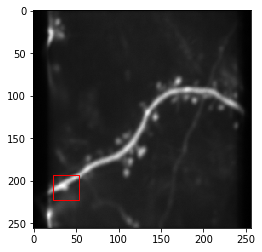

In [55]:
# preview image and single box using coordinates
fig,ax = plt.subplots(1)
ax.imshow(img_df.loc[0]['images'])
x_rect = img_df.loc[0]['x_y_coordinates'][0][0]-BOX_WIDTH/2
y_rect = img_df.loc[0]['x_y_coordinates'][1][0]-BOX_HEIGHT/2
rect = patches.Rectangle((x_rect,y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [65]:
#Apply padding to all images and shift coordinates respectively
img_df = img_df.apply(pad_image_and_shift_coordinates, axis = 1)
img_df.loc[0]


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


IndexError: ('list index out of range', 'occurred at index 2014')

In [76]:
# LEFT OFF HERE.
# for some reason only half the coordinates made their way over to the image. check out what's up

# row = img_df.loc[2013].copy()
# image = row['images']
# y,x,z = image.shape
# pad_y, pad_x, pad_z = max_y - y, max_x - x, max_z - z
# y1,y2 = np.floor(pad_y/2).astype(int), np.floor(pad_y/2).astype(int) + pad_y%2
# x1,x2 = np.floor(pad_x/2).astype(int), np.floor(pad_x/2).astype(int) + pad_x%2
# z1,z2 = np.floor(pad_z/2).astype(int), np.floor(pad_z/2).astype(int) + pad_z%2
# row['images_padded'] = np.pad(image, ((y1,y2),(x1,x2),(z1,z2)), mode = 'constant')
# # if row['x_y_coordinates'] is None:
# #     row['x_y_coordinates_shifted'] = None
# #     return row
# row['x_y_coordinates_shifted'] = row['x_y_coordinates'].copy()
# print(row)
# row['x_y_coordinates_shifted'][0] = row['x_y_coordinates'][0] + x1
# row['x_y_coordinates_shifted'][1] = row['x_y_coordinates'][1] + y1
# # return row

img_path                   C:\Users\smirnovm\Documents\Data\Labeled_Spine...
info_path                  C:\Users\smirnovm\Documents\Data\Labeled_Spine...
ImageID                                                               000016
x_y_coordinates            [[82.0, 383.0], [111.0, 386.0], [138.0, 382.0]...
images                     [[[2, 2, 2], [1, 1, 1], [0, 0, 0], [1, 1, 1], ...
split_image                                                             True
shape                                                          (416, 416, 3)
images_padded              [[[2, 2, 2], [1, 1, 1], [0, 0, 0], [1, 1, 1], ...
x_y_coordinates_shifted    [[82.0, 383.0], [111.0, 386.0], [138.0, 382.0]...
Name: 2013, dtype: object


In [ ]:
#preview image and single box using coordinates, after shifting has taken place
fig,ax = plt.subplots(1)
ax.imshow(img_df.loc[0]['images_padded'])
x_rect = img_df.loc[0]['x_y_coordinates_shifted'][0][0]-BOX_WIDTH/2
y_rect = img_df.loc[0]['x_y_coordinates_shifted'][1][0]-BOX_HEIGHT/2
rect = patches.Rectangle((x_rect,y_rect),BOX_WIDTH,BOX_HEIGHT,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
#map all coordinates to boxes
img_df['boxes'] = img_df['x_y_coordinates_shifted'].map(coords_to_boxes)
#preview dataframe
img_df.sample(2)

In [ ]:
# convert to array
images = img_df['images_padded'].as_matrix()
boxes = img_df['boxes'].as_matrix()
# save array
np.savez('spine_images_and_boxes',images = images,boxes = boxes)
# file can be loaded and accessed by 
# npzfile = np.load('spine_images_and_boxes.npz')
# npzfile['images']...

In [ ]:
# load sample underwater_data.npz to check what data should look like
# underwater_data = np.load('..//data//underwater_data.npz')

In [ ]:
# underwater_data['boxes'][50]

In [ ]:
#save two samples for testing training algorithm
np.savez('spine_images_and_boxes_2_sample', images = images[220:222], boxes = boxes[220:222])

In [ ]:
images[0].shape